In [12]:
import pandas as pd
import spacy

import networkx as nx

import re
import json
import itertools

import matplotlib.pyplot as plt



In [2]:
df = pd.read_csv('..\\data\\ocred\\files_df.csv', index_col = 0)
spacy.prefer_gpu()
nlp = spacy.load("nl_core_news_lg")
nlp_ministries = spacy.load("..\\data\\spacy labeled\\output\\model-last")

c:\Users\justin\AppData\Local\Programs\Python\Python39\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'nl_pipeline' (0.0.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [3]:
def getMatches(doc):

    # list of entities to include
    wantedTypes = ['EVENT','FAC','GPE','LAW','LOC', 'NORP', 'ORG', 'PERSON', 'PRODUCT', 'WORK_OF_ART']

    wantedEnts = []

    # for all entities, check if to include and clean up the string
    for ent in doc.ents:
        if ent.label_ in wantedTypes:
            text = str(ent.text)
            text = text.lower()
            text = re.sub(r'\n', ' ', text)
            text = text.strip()
            wantedEnts.append(text)    
    
    # retrun list of entities 
    return wantedEnts

In [4]:
def getEntities(text, name):
    try:
        text = re.sub('\n+', '\n', text)
        text = re.sub(' +', ' ', text)

        NERdoc = nlp(text)
        MinDoc = nlp_ministries(text)

        NERmatches = getMatches(NERdoc)
        MinMatches = getMatches(MinDoc)
    except:
        return {name:[]}

    return {name: list(set(NERmatches))}

In [5]:
def orderCheck(x, y):
    ordered = [x, y]
    ordered.sort()
    return ordered[0], ordered[1]

We want a dictionary with named documents as keys and and lists of entities that occur in it as values

In [6]:
def getEdges(n = 1000):
    testDf = df.sample(n, random_state=1)
    entities = testDf.apply(lambda row: getEntities(row['text'], row['full_name']), axis=1)

    entitiesDict = {}

    for d in entities:
        key = list(d.keys())[0]
        entitiesDict[key] = d[key]


    edges = {}

    for document in entitiesDict:
        if len(entitiesDict[document]) <= 1:
            continue
        
        for edge in itertools.combinations(entitiesDict[document], 2):
            node1, node2 = orderCheck(edge[0], edge[1])
            key = node1 + '\t' + node2 
            if key in edges:
                edges[key].append(document)
            else:
                edges[key] = [document]

    return edges

In [ ]:
edges = getEdges(n = 100)
G = nx.Graph()

for edge in edges:
    nodes = edge.split('\t')
    G.add_edge(nodes[0], nodes[1])
    G.add_edge(nodes[0], nodes[1], weight = len(edges[edge]))

x = [len(c) for c in list(nx.connected_components(G))]
x.sort(reverse=True)
limit = x[3]
del x
for component in list(nx.connected_components(G)):
    if len(component)<=limit:
        for node in component:
            G.remove_node(node)

print(f'Components: {nx.number_connected_components(G)}\nNumber of edges: {G.number_of_edges()}\nNumber of nodes: {G.number_of_nodes()}')
fig = plt.figure(1, figsize=(30, 30), dpi=60)
nx.draw(G, node_size = 50)

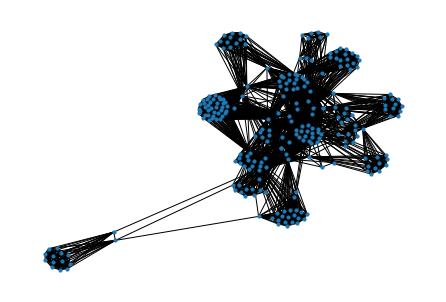

In [25]:
longest = 0 
nodeName = ''
for node in G.nodes:
    current = 0
    for neighbor in G.neighbors(node):
        current += 1
    if current > longest:
        longest = current
        nodeName = node
H = nx.subgraph(G, G.neighbors(nodeName))
nx.draw(H, node_size = 10)